<a href="https://colab.research.google.com/github/nurgulbagit/Data-Science-projects/blob/main/ds02_MNIST_Trees_Generalization_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Goal of this Notebook
* Introduction to Training Error, Testing Error and Generalization
* Intro to decision trees
* Intro to the MNIST data set
* Miscellaneous: some numpy commands, some visualization commands.

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from torchvision import datasets, transforms


We load the data set. This command loads it as a torch tensor.
We then convert it to a numpy array.

In [ ]:
import numpy as np
from torchvision import datasets, transforms

# Custom transform to convert tensor to numpy array and remove channel dimension
class ToNumpyNoChannel:
    def __call__(self, tensor):
        return tensor.squeeze(0).numpy()  # Remove channel dimension (C, H, W -> H, W)

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL image to PyTorch tensor
    transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize to [-1, 1]
    ToNumpyNoChannel()  # Convert tensor to numpy array and remove channel dimension
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Access data and labels as NumPy arrays
X_train = np.array([train_dataset[i][0] for i in range(len(train_dataset))])  # Features
y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))])  # Labels
X_test = np.array([test_dataset[i][0] for i in range(len(test_dataset))])    # Features
y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])    # Labels



Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 458kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.29MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.79MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
"""
Now we do a random permutation of the data. This is often a good idea,
especially when we don't know how the data were created. For example, maybe
the digits were all given in order.
"""

t0 = time.time()
random_state = check_random_state(0)
permutation = random_state.permutation(X_train.shape[0])
X_train = X_train[permutation]
y_train = y_train[permutation]
permutation = random_state.permutation(X_test.shape[0])
X_test = X_test[permutation]
y_test = y_test[permutation]


Basic rule: always look at your data.

In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of X_test: (10000, 28, 28)
Shape of y_test: (10000,)


In [ ]:
y_train

array([3, 6, 6, ..., 7, 1, 4])

In [ ]:
# How many times does each label appear in y_train and y_test

for i in range(10):
  c = str(i)
  ylist = y_train.tolist()
  num = ylist.count(c)
  print('The digit ', i, 'appears ', num, 'times')

The digit  0 appears  0 times
The digit  1 appears  0 times
The digit  2 appears  0 times
The digit  3 appears  0 times
The digit  4 appears  0 times
The digit  5 appears  0 times
The digit  6 appears  0 times
The digit  7 appears  0 times
The digit  8 appears  0 times
The digit  9 appears  0 times


In [ ]:
# Let's try again using some numpy commands

# occurrences of each digit in y_train
unique_digits, counts = np.unique(y_train, return_counts=True)

# results
for digit, count in zip(unique_digits, counts):
    print(f"Digit {digit}: {count} occurrences")

Digit 0: 5923 occurrences
Digit 1: 6742 occurrences
Digit 2: 5958 occurrences
Digit 3: 6131 occurrences
Digit 4: 5842 occurrences
Digit 5: 5421 occurrences
Digit 6: 5918 occurrences
Digit 7: 6265 occurrences
Digit 8: 5851 occurrences
Digit 9: 5949 occurrences


In [ ]:
# Now let's have a look at some element of X and the corresponding element of y
print('The label is', y_train[0])
print('The feature vector is', X_train[0])

The label is 3
The feature vector is [[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1. 

The label makes sense. The feature vector not so much.

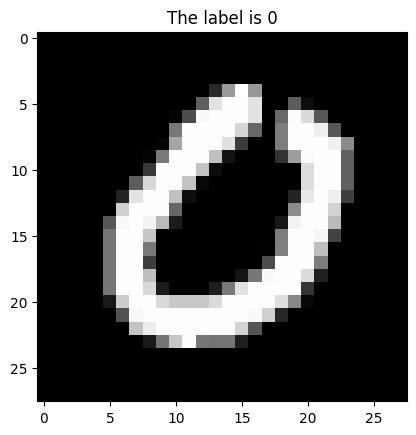

In [ ]:
# Since our data are handwritten digits, let's display the data
# so that we can see it.

# pick an element to display
index = 12
img = X_train[index]
label = y_train[index]
#img = img.reshape((28, 28))

# Plot it along with its label
plt.title('The label is {label}'.format(label=label))
plt.imshow(img, cmap='gray')
plt.show()

## How images are stored: Pixel intensities

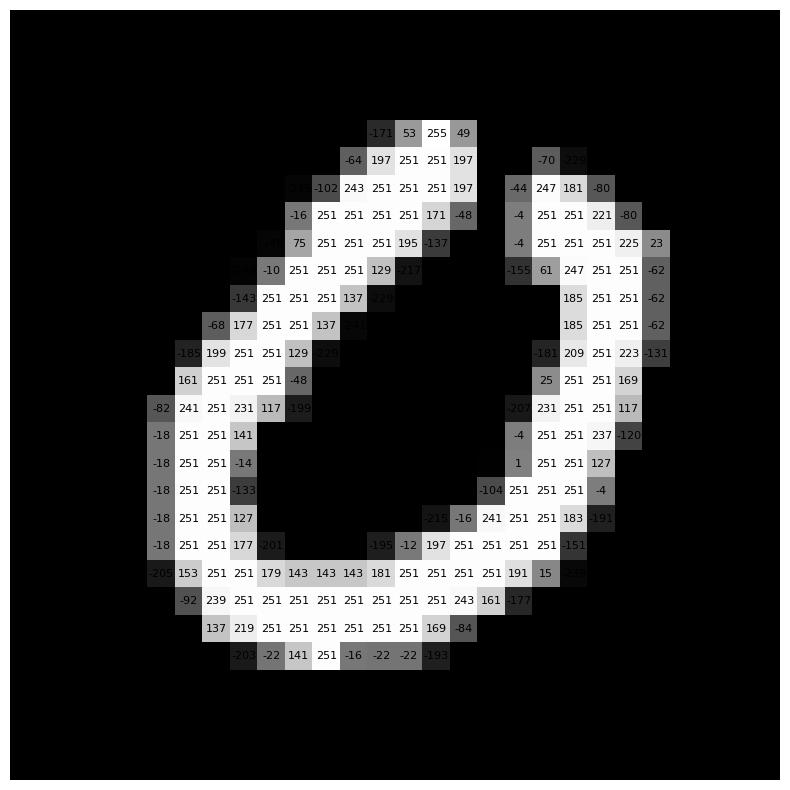

In [ ]:
image_np = (img.squeeze() * 255).astype(int)

# Plot the image with pixel intensities
plt.figure(figsize=(10, 10))
for i in range(image_np.shape[0]):
    for j in range(image_np.shape[1]):
        plt.text(j, i, str(image_np[i, j]), va='center', ha='center', fontsize=8, color="black")

plt.imshow(image_np, cmap="gray", interpolation="none")
plt.axis("off")
plt.show()


# Decision Trees
We will now train a decision tree to do automatic digit recognition.

In [ ]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))


In [ ]:
X_train[0]

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

In [ ]:
# There are 60,000 training data points. Let's just pick a few of them.
# We've already shuffled, so it's safe to just pick the first ones.
N_tr = 20
train_samples = N_tr
X_tr = X_train[:N_tr,:]
y_tr = y_train[:N_tr]
# check size
X_tr.shape

(20, 784)

In [ ]:
# We now create a decision tree.
# The only parameter we pass is the max depth
decision_tree = tree.DecisionTreeClassifier(max_depth=5)


Train score: 1.0000


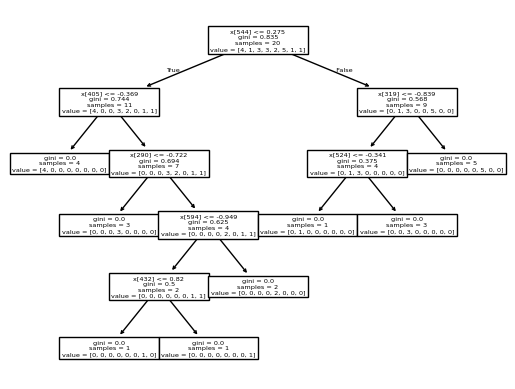

In [ ]:
# Now we actually train it -- this is the computationally intensive step
decision_tree.fit(X_tr, y_tr)

# This is what it looks like
tree.plot_tree(decision_tree)

# And this is its accuracy on the training data
train_score = decision_tree.score(X_tr,y_tr)
print("Train score: %.4f" % train_score)



# Visualizing Errors
It's useful again to visualize some examples, especially where the prediction was wrong.

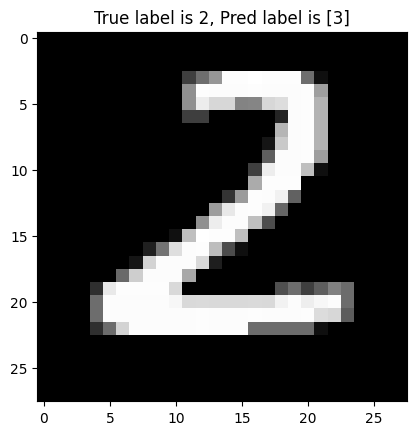

array([3])

In [ ]:
# pick an element to display from the test images
index = 13
img = X_test[index]
y_true = y_test[index]
img = img.reshape((28, 28))

# get the predicted label
y_hat = decision_tree.predict(X_test[index].reshape(1,-1))

# Plot it along with its label
plt.title('True label is {label_t}, Pred label is {label_p}'.format(label_t=y_true,label_p = y_hat))
plt.imshow(img, cmap='gray')
plt.show()
y_hat

# Training Error and Testing Error vs Depth

In [ ]:
# Again a train-test split
#train_samples = 50000
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, train_size=train_samples, test_size=70000-train_samples, random_state=0)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

training_scores = []
testing_scores = []
depth_values = range(15)
for depth in depth_values:
    dt = tree.DecisionTreeClassifier(max_depth=depth+1, criterion='gini')
    dt.fit(X_train,y_train)
    train_score = dt.score(X_train,y_train)
    test_score = dt.score(X_test, y_test)
    training_scores.append(train_score)
    testing_scores.append(test_score)

In [ ]:
print('These are the training scores:',training_scores)
print('These are the testing scores:',testing_scores)

These are the training scores: [0.1982, 0.34181666666666666, 0.49151666666666666, 0.5898833333333333, 0.6722666666666667, 0.73825, 0.7866, 0.8262666666666667, 0.8665166666666667, 0.8995333333333333, 0.9276833333333333, 0.94915, 0.9649, 0.97695, 0.9844166666666667]
These are the testing scores: [0.1994, 0.3447, 0.4953, 0.5957, 0.6747, 0.7416, 0.7853, 0.8186, 0.8501, 0.8663, 0.8741, 0.8778, 0.881, 0.8815, 0.8811]


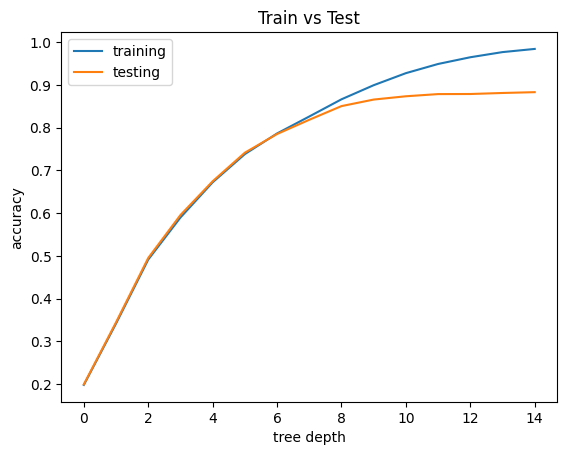

In [ ]:
# Easier to see them on a graph, vs depth of tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(training_scores,label='training')
ax.plot(testing_scores,label='testing')
ax.set_xlabel('tree depth')  # Add an x-label to the axes.
ax.set_ylabel('accuracy')  # Add a y-label to the axes.
ax.set_title("Train vs Test")  # Add a title to the axes.
ax.legend();  # Add a legend.

## Comments / Thoughts?

# Let's try using Bagging

You can run the below if you'd like. We will return to it a little later when we are discussing Ensembling, Bagging, Boosting and Random Forests.

-------

1. Make bootstrapped copies of the data.
2. Train trees on the copies of the data
3. Average

In [ ]:
# write a function that takes several models
# evaluates all of them on X_test and returns
# the label that is the majority vote
from scipy.stats import mode

def ensemble_predict(models, X_test):
    predictions = [model.predict(X_test) for model in models]
    return mode(predictions, axis=0)[0]

In [ ]:
M  = 30
models = []
accuracies_test = []

# fix random seed
np.random.seed(42)

for i in range(M):
    print(i)
    bootstrapped_indices = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
    X_train_boot = X_train[bootstrapped_indices]
    y_train_boot = y_train[bootstrapped_indices]
    model = tree.DecisionTreeClassifier(max_depth=10)
    model.fit(X_train_boot, y_train_boot)
    models.append(model)
    ensemble_labels = ensemble_predict(models, X_test)
    accuracy = np.mean(ensemble_labels == y_test)
    accuracies_test.append(accuracy)
    print(accuracy)

0
0.8557
1
0.8582
2
0.8935
3
0.9059
4
0.9091
5
0.9162
6
0.9182
7
0.9224
8
0.9242
9
0.9263
10
0.9278
11
0.9298
12
0.9296
13
0.9305
14
0.9293
15
0.9314
16
0.9303
17
0.9325
18
0.9321
19
0.9326
20
0.9325
21
0.9333
22
0.9325
23
0.9326
24
0.9328
25
0.9323
26
0.9319
27
0.9319
28
0.9313
29
0.9321


### Now let's try random forests

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth = 10, random_state=42)
rf.fit(X_train, y_train)
labels = rf.predict(X_test)
accuracy = np.mean(labels == y_test)
print(accuracy)

0.9488
